## IMPORT

In [1]:
import pandas as pd
import numpy as np

from torchtext.data import Field, TabularDataset, BucketIterator
import torchtext.data.functional as f
from torchtext.data.utils import get_tokenizer
import spacy
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm
tqdm.pandas()

import time

import matplotlib.pyplot as plt
%matplotlib inline


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## DATA LOADING AND PREPROCESSING

In [2]:
train = pd.read_csv('../input/uci-drug-review-dataset/drugLibTrain_raw.tsv', sep='\t')
train.dropna(how='any', inplace = True)
test = pd.read_csv('../input/uci-drug-review-dataset/drugLibTest_raw.tsv', sep='\t')
text_columns = ['benefitsReview','sideEffectsReview', 'commentsReview']

In [3]:
for col in text_columns:
    train[col] = train[col].progress_apply(lambda x: x.replace('\r\r\n',''))
    test[col] = test[col].progress_apply(lambda x: x.replace('\r\r\n',''))

  0%|          | 0/3096 [00:00<?, ?it/s]

  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/3096 [00:00<?, ?it/s]

  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/3096 [00:00<?, ?it/s]

  0%|          | 0/1036 [00:00<?, ?it/s]

In [4]:
nlp = spacy.load('en_core_web_sm')
def clear_review(sentence):
    """Function to lemmatize words and remove punctuation 
    Args:
    sentence: sentence to process, str
    Return:
    clean sentence, str
    """
    words = nlp(sentence)
    s = [''.join(word.lemma_) for word in words if word.is_punct == False and
        word.is_digit==False and word.pos_ != 'PRON']
    return ' '.join(map(str,s))

for col in text_columns:
    train[col] = train[col].progress_apply(lambda x: clear_review(x).lower().strip())
    test[col] = test[col].progress_apply(lambda x: clear_review(x).lower().strip())

  0%|          | 0/3096 [00:00<?, ?it/s]

  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/3096 [00:00<?, ?it/s]

  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/3096 [00:00<?, ?it/s]

  0%|          | 0/1036 [00:00<?, ?it/s]

In [5]:
#remaining text feauters and target only
df_train = train.loc[:,['benefitsReview','sideEffectsReview', 'commentsReview','rating']]
df_test = test.loc[:,['benefitsReview','sideEffectsReview', 'commentsReview','rating']]
#DataFrame to build full vocabulary
X = df_train.append(df_test).drop('rating',axis=1) # я не уверен, что так можно и это не лик, но хочется использовать наиболее полный словарь


In [6]:
df_train, df_val = train_test_split(df_train, test_size = 0.05,
                                    random_state = 42)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)


(2941, 4)
(155, 4)
(1036, 4)


In [7]:
df_train.to_csv('df_train.csv')
df_val.to_csv('df_val.csv')
df_test.to_csv('df_test.csv')

# DL SETUP

In [8]:
def tokenize(text):
    return [tok.text for tok in nlp.tokenizer(text)]


review = Field(sequential=True, use_vocab=True, tokenize=tokenize, lower=True)
rating = Field(sequential=False, use_vocab=False)

fields = {"benefitsReview": ("bnf", review), "sideEffectsReview": ("sef", review),
          "commentsReview": ("cmt", review), "rating": ("rtg", rating)}

train_data, val_data, test_data = TabularDataset.splits(
    path="./", train="df_train.csv",validation = 'df_val.csv', test="df_train.csv", format="csv",
    fields=fields)


#создадим словарь по обрезанным от рейтинга данным обеих частей всем трем типам ревью сразу
pr_benefits = X['benefitsReview'].apply(lambda x: review.preprocess(x))
pr_effects = X['sideEffectsReview'].apply(lambda x: review.preprocess(x))
pr_comments = X['commentsReview'].apply(lambda x: review.preprocess(x))
preprocessed_text = pr_benefits.append([pr_effects,pr_comments])

review.build_vocab(
    preprocessed_text, 
    vectors='glove.6B.300d'
)

vocab = review.vocab
print(vocab.vectors.shape)

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:52: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

torch.Size([14389, 300])


In [9]:
train_iterator, val_iterator, test_iterator = BucketIterator.splits(
    (train_data,val_data, test_data), batch_size=64, device=device,
    sort = False
)

/opt/conda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [186]:
class RNN_GRU(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embed_size)
        self.do = nn.Dropout(p=0.2)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers, dropout = 0.5)
        self.fc_out = nn.Linear(hidden_size, 1)


    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc_out.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()
  
    def forward(self, x):
        # Initializing hidden units and cells state

        embedded = self.embedding(x)
        do = self.do(embedded)
        outputs, _ = self.rnn(do)
        prediction = self.fc_out(outputs[-1, :, :])

        return prediction
  

    def train(self, train_iterator, num_epochs, criterion, optimizer, val_iterator=None):
        log = []
        prev_loss = 9999
        for epoch in range(num_epochs):
            print(f'{epoch} epoch started')
            train_losses = []
            for batch_idx, batch in enumerate(train_iterator):
                # Get data to cuda if possible
                # Here we're trying to take in account all text features
                data_bnf = batch.bnf.to(device=device)
                data_sef = batch.sef.to(device=device)
                data_cmt = batch.cmt.to(device=device)
        
                targets = batch.rtg.to(device=device)

                # forward
                pr_bnf = self(data_bnf)
                pr_sef = self(data_sef)
                pr_cmt = self(data_cmt)
                prediction = (pr_bnf+pr_sef+pr_cmt) / 3
                loss = criterion(prediction.squeeze(1).float(), targets.float())

                # backward
                optimizer.zero_grad()
                loss.backward()

                # gradient descent
                optimizer.step()
                train_losses.append(loss.item())
            print('train loss on epoch {} : {:.3f}'.format(epoch, np.mean(train_losses)))
            if val_iterator is not None:
                test_losses = []
                for t_batch in val_iterator:
                    with torch.no_grad():
                        data_bnf = t_batch.bnf.to(device=device)
                        data_sef = t_batch.sef.to(device=device)
                        data_cmt = t_batch.cmt.to(device=device)
                        targets = t_batch.rtg.to(device=device)
                        pr_bnf = self(data_bnf)
                        pr_sef = self(data_sef)
                        pr_cmt = self(data_cmt)
                        prediction = (pr_bnf+pr_sef+pr_cmt) / 3
                        loss = criterion(prediction.squeeze(1).float(), targets.float())
                    test_losses.append(loss.item())
                new_loss = np.mean(test_losses)    
                print('test loss on epoch {}: {:.3f}'.format(epoch, new_loss))
                scheduler.step(new_loss)
                if new_loss<prev_loss:
                    print(f'making checkpoint on loss value: {new_loss}')
                    prev_loss = new_loss
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': new_loss,
                    }, f'model_loss{new_loss}.ckpt')
                print('-'*50)
            log.append([np.mean(train_losses), np.mean(test_losses)])
            pd.DataFrame(log, columns=['train','val']).to_csv('train_log.csv')
    
    def evaluate(self, test_iterator):
        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
        with torch.no_grad():
            for batch in test_iterator:
                # loading predictors
                data_bnf = batch.bnf.to(device=device)
                data_sef = batch.sef.to(device=device)
                data_cmt = batch.cmt.to(device=device)
                #targets
                targets = batch.rtg.to(device=device)
                # predicting
                pr_bnf = self(data_bnf)
                pr_sef = self(data_sef)
                pr_cmt = self(data_cmt)
                prediction = (pr_bnf+pr_sef+pr_cmt) / 3
                predlist = torch.cat([predlist,prediction.view(-1).cpu()])
                lbllist = torch.cat([lbllist,targets.view(-1).cpu()])
        conf_mat=confusion_matrix(lbllist.numpy(), predlist.type(torch.uint8).numpy(),
                                 labels = [i for i in range(1,11)])
        class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
        return conf_mat, class_accuracy[1:], np.mean(class_accuracy[1:])

# DEEP LEARNING WITH PYTORCH

In [189]:
# Hyperparameters
input_size = len(review.vocab)
hidden_units = 512
num_layers = 1
embedding_size = 300
learning_rate = 0.005
num_epochs = 100

loss_function = nn.MSELoss()
model = RNN_GRU(input_size, embedding_size, hidden_units, num_layers).to(device)
model.init_weights()
# loading pretrained embeddings to our model
pretrained_embeddings = review.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [190]:
# checkpoint = torch.load('./model.ckpt')
# model.load_state_dict(checkpoint['model_state_dict'])

optimizer = Adam(model.parameters(), lr=learning_rate)

scheduler = ReduceLROnPlateau(optimizer, mode='min',
                              factor=0.1, patience=1, verbose=True)

model.train(train_iterator, num_epochs, loss_function, optimizer, val_iterator)

0 epoch started
train loss on epoch 0 : 122.978
test loss on epoch 0: 8.721
making checkpoint on loss value: 8.72138500213623
--------------------------------------------------
1 epoch started
train loss on epoch 1 : 8.693
test loss on epoch 1: 8.551
making checkpoint on loss value: 8.550884087880453
--------------------------------------------------
2 epoch started
train loss on epoch 2 : 8.549
test loss on epoch 2: 8.775
--------------------------------------------------
3 epoch started
train loss on epoch 3 : 7.379
test loss on epoch 3: 7.139
making checkpoint on loss value: 7.13922119140625
--------------------------------------------------
4 epoch started
train loss on epoch 4 : 4.570
test loss on epoch 4: 7.068
making checkpoint on loss value: 7.067831039428711
--------------------------------------------------
5 epoch started
train loss on epoch 5 : 2.437
test loss on epoch 5: 6.370
making checkpoint on loss value: 6.369820435841878
----------------------------------------------

KeyboardInterrupt: 

In [191]:
train_log = pd.read_csv('./train_log.csv')
train_log.drop('Unnamed: 0', axis = 1, inplace = True)

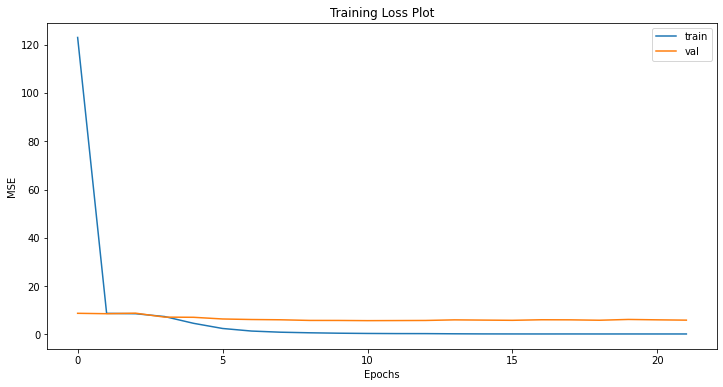

In [192]:
train_log.plot(kind='line', figsize = (12,6))
plt.title('Training Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

# Evaluation

In [195]:
checkpoint = torch.load('./model_loss5.7623138427734375.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])
conf_mat, class_acc, mean_class_acc = model.evaluate(test_iterator)
print(f"Mean accuracy of model: {np.mean((class_acc))}")

# class accuracy separately
print(f"Separate Class Accuracy: {class_acc}")

Mean accuracy of model: 50.42853219213844
Separate Class Accuracy: [60.41666667 54.22535211 53.125      51.33333333 48.68421053 51.82926829
 50.18867925 49.23413567 34.82014388]


In [196]:
#Confusion Matrix
labels = [i for i in range(1,11)]
pd.DataFrame(conf_mat, columns = labels, index = labels)

,1,2,3,4,5,6,7,8,9,10
1,168,45,8,1,0,0,0,0,0,0
2,29,58,8,1,0,0,0,0,0,0
3,3,44,77,17,1,0,0,0,0,0
4,0,2,34,51,7,1,1,0,0,0
5,0,0,4,57,77,10,2,0,0,0
6,0,0,0,5,59,74,14,0,0,0
7,0,0,0,0,10,134,170,13,0,1
8,0,0,0,0,0,10,238,266,16,0
9,0,0,0,0,0,1,19,209,225,3
10,0,0,0,0,0,0,2,28,423,242


The network is clearly overfitting but according to confusion matrix it strongly tends to divide positive and negative scores.